In [1]:
import numpy as np
import torch_geometric
print(torch_geometric.__version__)

def calculate_force(particle1, particle2):
    dx = particle2[0] - particle1[0]
    dy = particle2[1] - particle1[1]
    r_squared = dx**2 + dy**2
    
    if r_squared == 0:
        return [0, 0]  # Avoid division by zero
    
    force_magnitude = particle1[2] * particle2[2] / r_squared
    force_x = force_magnitude * dx / np.sqrt(r_squared)
    force_y = force_magnitude * dy / np.sqrt(r_squared)
    
    return [force_x, force_y]

def generate_particle_dataset(num_points):
    dataset = []
    min_distance = 0.5  # Minimum distance constraint
    
    for i in range(num_points):
        # Generate the points in different locations to unbias learning
        x_beginning = None
        y_beginning = None
        if i % 4 == 0:
            x_beginning = 0
            y_beginning = 0
        elif i % 4 == 1:
            x_beginning = 1
            y_beginning = 0
        elif i % 4 == 2:
            x_beginning = 0
            y_beginning = 1
        else:
            x_beginning = 1
            y_beginning = 1

        data_point = []
        positions = []

        # Generate 3 particles with unique positions separated by at least 0.1
        for _ in range(3):
            while True:
                x = np.random.uniform(x_beginning, x_beginning + 1)
                y = np.random.uniform(y_beginning, y_beginning + 1)
                position = (x, y)

                # Check distance against all existing particles
                if all(np.sqrt((x - px)**2 + (y - py)**2) >= min_distance for px, py in positions):
                    positions.append(position)
                    break
            
            mass = np.random.uniform(0.1, 6)
            particle = [x, y, mass, [0, 0]]  # [x, y, mass, [force_x, force_y]]
            data_point.append(particle)
        
        # Calculate forces
        for i in range(3):
            for j in range(3):
                if i != j:
                    force = calculate_force(data_point[i], data_point[j])
                    data_point[i][3][0] += force[0]
                    data_point[i][3][1] += force[1]
        
        dataset.append(data_point)
    
    return dataset

# Generate a dataset with 100 data points
num_points = 50000
particle_dataset = generate_particle_dataset(num_points)

# Print the first few data points as an example
for i, data_point in enumerate(particle_dataset[:3]):
    print(f"Data point {i + 1}:")
    for j, particle in enumerate(data_point):
        print(f"  Particle {j + 1}: [x = {particle[0]:.6f}, y = {particle[1]:.6f}, mass = {particle[2]:.4f}, force = [{particle[3][0]:.6e}, {particle[3][1]:.6e}]]")
    print()

2.5.3
Data point 1:
  Particle 1: [x = 0.149864, y = 0.609061, mass = 3.2163, force = [1.315926e+01, -9.190161e+00]]
  Particle 2: [x = 0.680734, y = 0.775507, mass = 0.5589, force = [-5.964455e+00, -3.586165e+00]]
  Particle 3: [x = 0.520856, y = 0.076887, mass = 1.7430, force = [-7.194807e+00, 1.277633e+01]]

Data point 2:
  Particle 1: [x = 1.431693, y = 0.245919, mass = 5.8573, force = [2.792296e+01, 5.580450e+01]]
  Particle 2: [x = 1.968450, y = 0.671466, mass = 2.6981, force = [-4.138567e+01, -1.860189e+01]]
  Particle 3: [x = 1.453848, y = 0.751212, mass = 1.5248, force = [1.346271e+01, -3.720261e+01]]

Data point 3:
  Particle 1: [x = 0.169096, y = 1.462465, mass = 4.6790, force = [4.429818e+01, 8.257361e-03]]
  Particle 2: [x = 0.734402, y = 1.937521, mass = 2.3584, force = [-1.583556e+01, -2.389524e+01]]
  Particle 3: [x = 0.711769, y = 1.217320, mass = 2.3953, force = [-2.846262e+01, 2.388698e+01]]



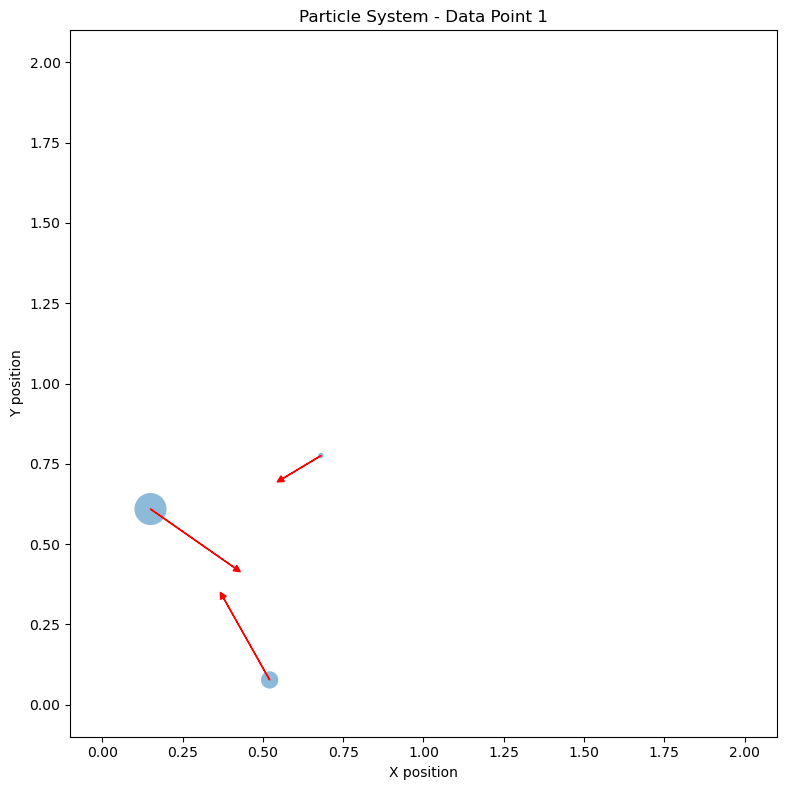

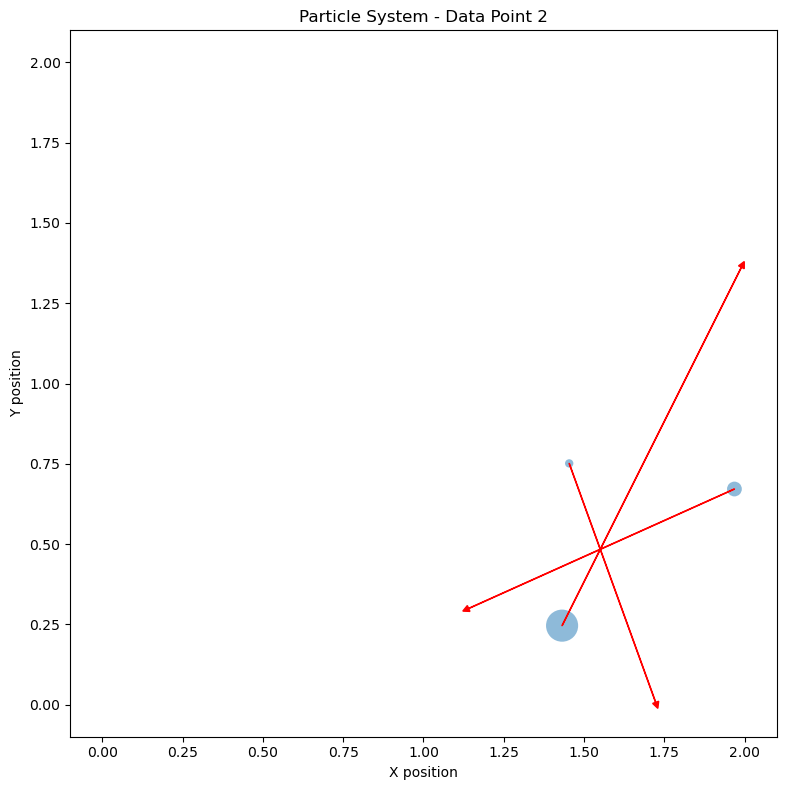

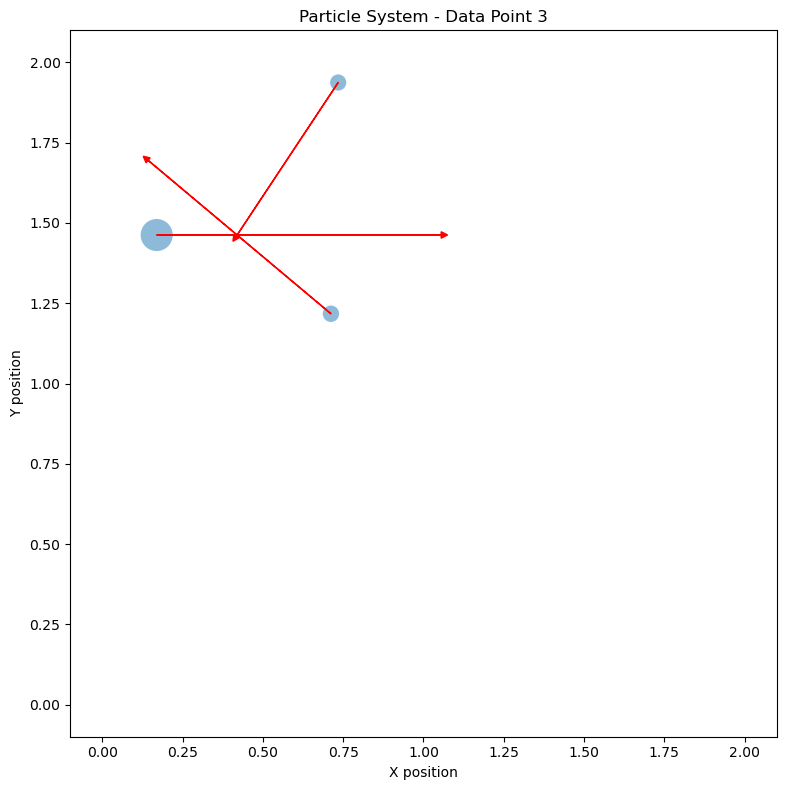

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_particle_system(data_point, index):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set plot limits
    ax.set_xlim(-0.1, 2.1)
    ax.set_ylim(-0.1, 2.1)
    
    # Find the maximum mass for scaling
    max_mass = max(particle[2] for particle in data_point)
    
    # Plot particles and forces
    for particle in data_point:
        x, y, mass, force = particle
        
        # Plot particle as a circle
        radius = (mass / max_mass) / 20  # Scale size relative to maximum mass
        circle = plt.Circle((x, y), radius=radius, fill=True, alpha=0.5)
        ax.add_artist(circle)
        
        # Plot force arrow
        force_x, force_y = force
        # Scale arrow length
        scale = 0.02
        ax.arrow(x, y, force_x * scale, force_y * scale, 
                    head_width=0.02, head_length=0.02, fc='r', ec='r')
    
    ax.set_aspect('equal')
    ax.set_title(f'Particle System - Data Point {index}')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    
    plt.tight_layout()
    plt.show()

# Assuming particle_dataset is already generated
# Plot the first 3 data points
for i, data_point in enumerate(particle_dataset[:3]):
    plot_particle_system(data_point, i+1)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data

class EdgeModel(MessagePassing):
    def __init__(self):
        super(EdgeModel, self).__init__(aggr='add')  # "Add" aggregation.
        self.mlp = nn.Sequential(
            nn.Linear(6, 64),  # 6 = 2 (pos) + 1 (mass) for each particle
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)  # Output 2D force
        )

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        tmp = torch.cat([x_i, x_j], dim=1)  # Concatenate features of both nodes
        out = self.mlp(tmp)
        return out

class NodeModel(nn.Module):
    def __init__(self):
        super(NodeModel, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(5, 32),  # 5 = 2 (pos) + 1 (mass) + 2 (aggregated force)
            nn.ReLU(),
            nn.Linear(32, 5),
            nn.ReLU(),
            nn.Linear(5, 2)  # Output 2D force
        )

    def forward(self, x, edge_index, edge_attr):
        # The edge attributes have already been added when the Message Passing layer was
        # applied. Simply concatenate them with the node's features
        out = torch.cat([x, edge_attr], dim=1)
        # Not using the mlp for now
        return edge_attr

class ParticleGNN(nn.Module):
    def __init__(self):
        super(ParticleGNN, self).__init__()
        self.edge_model = EdgeModel()
        self.node_model = NodeModel()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Edge Model
        edge_attr = self.edge_model(x, edge_index)
        
        # Node Model
        out = self.node_model(x, edge_index, edge_attr)
        
        return out

# Create a sample input
def create_sample_data(num_particles=3):
    x = torch.rand(num_particles, 3)  # [x, y, mass] for each particle
    edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                               [1, 2, 0, 2, 0, 1]], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index)
    return data

# Initialize the model
model = ParticleGNN()

# Create sample data
data = create_sample_data()
print(data)
print("node info: ", data.x)

# Forward pass
output = model(data)

print("Input:")
print(data.x)
print("\nOutput (forces):")
print(output)


Data(x=[3, 3], edge_index=[2, 6])
node info:  tensor([[0.6835, 0.5313, 0.7215],
        [0.9342, 0.8007, 0.2793],
        [0.2489, 0.2876, 0.1206]])
Input:
tensor([[0.6835, 0.5313, 0.7215],
        [0.9342, 0.8007, 0.2793],
        [0.2489, 0.2876, 0.1206]])

Output (forces):
tensor([[0.0334, 0.2670],
        [0.0207, 0.2504],
        [0.0365, 0.2837]], grad_fn=<ScatterAddBackward0>)


In [4]:
x_dataset = []
y_dataset = []
edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                           [1, 2, 0, 2, 0, 1]], dtype=torch.long)
for data_point in particle_dataset:
    x = torch.tensor([particle[:3] for particle in data_point], dtype=torch.float32)
    y = torch.tensor([particle[3] for particle in data_point], dtype=torch.float32)
    x_dataset.append(Data(x=x, edge_index=edge_index))
    y_dataset.append(y)


for particle in particle_dataset[:2]:
    print(particle)

print("\n")

for x in x_dataset[:2]:
    print(x.x)

print("\n")

for y in y_dataset[:2]:
    print(y)

[[0.1498640782836983, 0.6090611796430103, 3.2163075288528966, [13.159261696118076, -9.190160929253555]], [0.6807342233349684, 0.7755073468825379, 0.5588819531628262, [-5.964454907465498, -3.5861647254793647]], [0.5208562161146573, 0.07688716138579466, 1.7429892897282435, [-7.194806788652578, 12.776325654732918]]]
[[1.4316928877208386, 0.2459189342244078, 5.857333513948074, [27.922962943367466, 55.804499180341]], [1.9684503570502616, 0.6714661668243029, 2.698091100858401, [-41.38567135584734, -18.601889258252033]], [1.4538482760867266, 0.7512122550252601, 1.5247782399742746, [13.462708412479877, -37.20260992208896]]]


tensor([[0.1499, 0.6091, 3.2163],
        [0.6807, 0.7755, 0.5589],
        [0.5209, 0.0769, 1.7430]])
tensor([[1.4317, 0.2459, 5.8573],
        [1.9685, 0.6715, 2.6981],
        [1.4538, 0.7512, 1.5248]])


tensor([[13.1593, -9.1902],
        [-5.9645, -3.5862],
        [-7.1948, 12.7763]])
tensor([[ 27.9230,  55.8045],
        [-41.3857, -18.6019],
        [ 13.4627, -3

Using device: cuda
Epoch [1/100], Loss: 117.1498, Learning Rate: 0.0190000000
Epoch [2/100], Loss: 9.9385, Learning Rate: 0.0180500000
Epoch [3/100], Loss: 7.2529, Learning Rate: 0.0171475000
Epoch [4/100], Loss: 5.0895, Learning Rate: 0.0162901250
Epoch [5/100], Loss: 5.2528, Learning Rate: 0.0154756187
Epoch [6/100], Loss: 6.6897, Learning Rate: 0.0147018378
Epoch [7/100], Loss: 3.6576, Learning Rate: 0.0139667459
Epoch [8/100], Loss: 3.3562, Learning Rate: 0.0132684086
Epoch [9/100], Loss: 3.0063, Learning Rate: 0.0126049882
Epoch [10/100], Loss: 3.5779, Learning Rate: 0.0119747388
Epoch [11/100], Loss: 3.0906, Learning Rate: 0.0113760018
Epoch [12/100], Loss: 2.6098, Learning Rate: 0.0108072018
Epoch [13/100], Loss: 2.2448, Learning Rate: 0.0102668417
Epoch [14/100], Loss: 1.8625, Learning Rate: 0.0097534996
Epoch [15/100], Loss: 1.8436, Learning Rate: 0.0092658246
Epoch [16/100], Loss: 2.6534, Learning Rate: 0.0088025334
Epoch [17/100], Loss: 1.6340, Learning Rate: 0.0083624067
Ep

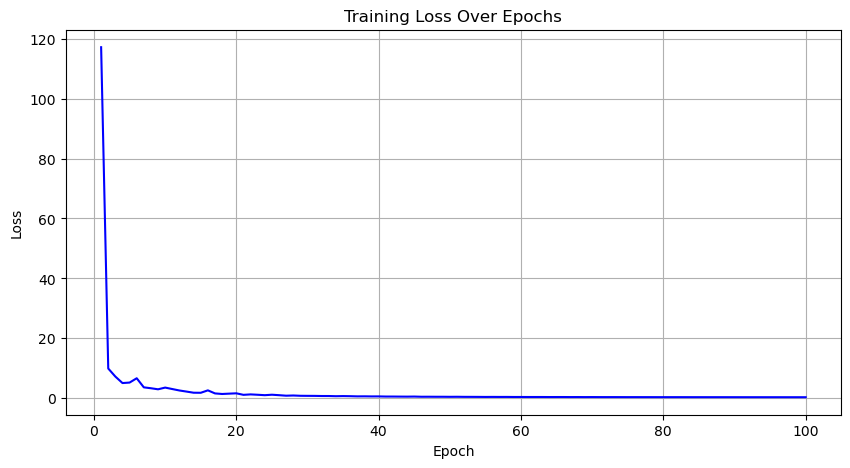

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch_geometric.loader import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the device
model = model.to(device)

# Create a custom dataset that combines x (graph data) and y (labels)
class GraphDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data  # List of torch_geometric.data.Data objects
        self.y_data = y_data  # Corresponding labels

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]  # Get the graph data
        y = self.y_data[idx]  # Get the corresponding label
        x.y = y  # Assign the label to the graph data object
        return x

# Initialize the custom dataset
dataset = GraphDataset(x_dataset, y_dataset)

# Train-test split
train_size = 0.8  # Define the proportion of training data
x_train, x_test, y_train, y_test = train_test_split(
    dataset.x_data, dataset.y_data, train_size=train_size, random_state=42
)

# Create training and testing datasets
train_dataset = GraphDataset(x_train, y_train)
test_dataset = GraphDataset(x_test, y_test)

# Use PyTorch Geometric DataLoader to load data in batches
batch_size = 64  # Set your desired batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)

# Define a learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)  # Reduce LR by factor of gamma every step_size epochs

# Training loop
num_epochs = 100  # Define the number of epochs
loss_values = []  # List to store loss values for each epoch

for epoch in range(num_epochs):
    model.train()
    
    # Training phase
    epoch_loss = 0.0  # Initialize epoch loss
    for batch in train_loader:
        # Move data to the device
        batch = batch.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(batch)
        
        # Compute loss
        loss = criterion(output, batch.y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate epoch loss
        epoch_loss += loss.item()
    
    # Average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    loss_values.append(avg_epoch_loss)  # Store the average loss
    
    # Update the learning rate
    scheduler.step()  # Call the scheduler step at the end of each epoch
    
    # Print loss for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.10f}')

print("Training complete!")

# Plot the loss values
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_values, color='b', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

In [6]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to store test loss and metrics
test_loss = 0.0  # Total loss over the test set
test_samples = 0  # Total number of samples

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch in test_loader:
        # Move data to the device
        batch = batch.to(device)
        
        # Forward pass
        output = model(batch)
        
        # Compute loss
        loss = criterion(output, batch.y)
        test_loss += loss.item() * batch.num_graphs  # Sum up batch loss, multiplied by number of graphs in the batch
        test_samples += batch.num_graphs  # Accumulate the total number of graphs

# Calculate the average test loss
avg_test_loss = test_loss / test_samples

print(f'Average Test Loss: {avg_test_loss:.4f}')

Average Test Loss: 0.3798


In [7]:
# Ensure the model is in evaluation mode
model.eval()

# Move the model to the device if not already done
model = model.to(device)

# Prepare to store predictions
predicted_forces = []

# Iterate through the dataset to predict forces
for x in x_dataset:
    # Move data to the device
    x = x.to(device)
    
    # Make predictions
    with torch.no_grad():
        output = model(x)
        predicted_forces.append(output.cpu().numpy())

# Convert predicted forces to a format suitable for plotting
predicted_particle_dataset = []
for i, data_point in enumerate(particle_dataset[:6]):
    predicted_data_point = []
    for j, particle in enumerate(data_point):
        predicted_force = predicted_forces[i][j]  # Get predicted force
        particle_with_predicted_force = [particle[0], particle[1], particle[2], predicted_force.tolist()]
        predicted_data_point.append(particle_with_predicted_force)
    predicted_particle_dataset.append(predicted_data_point)

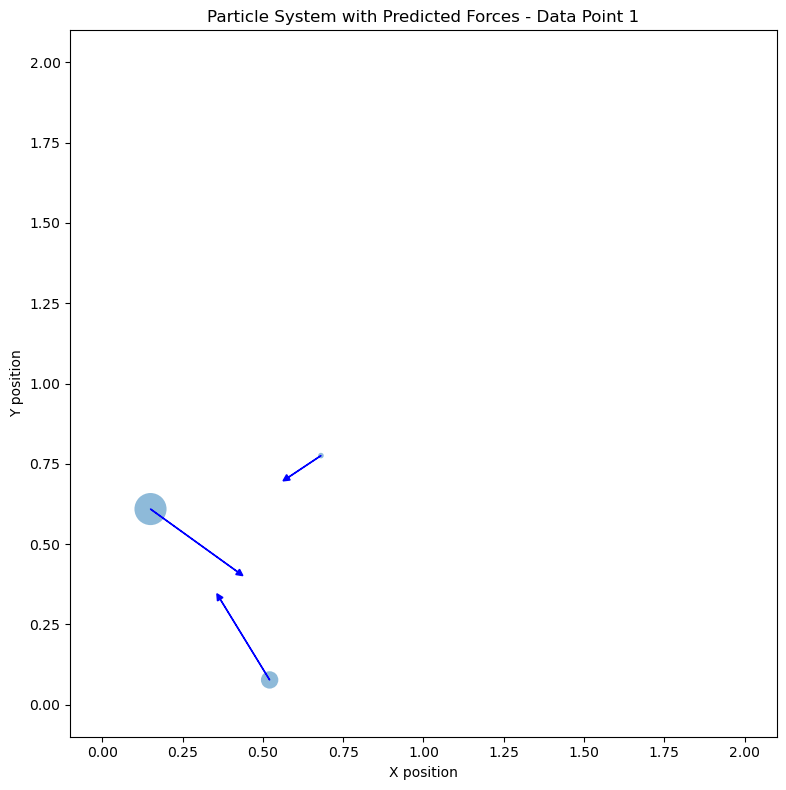

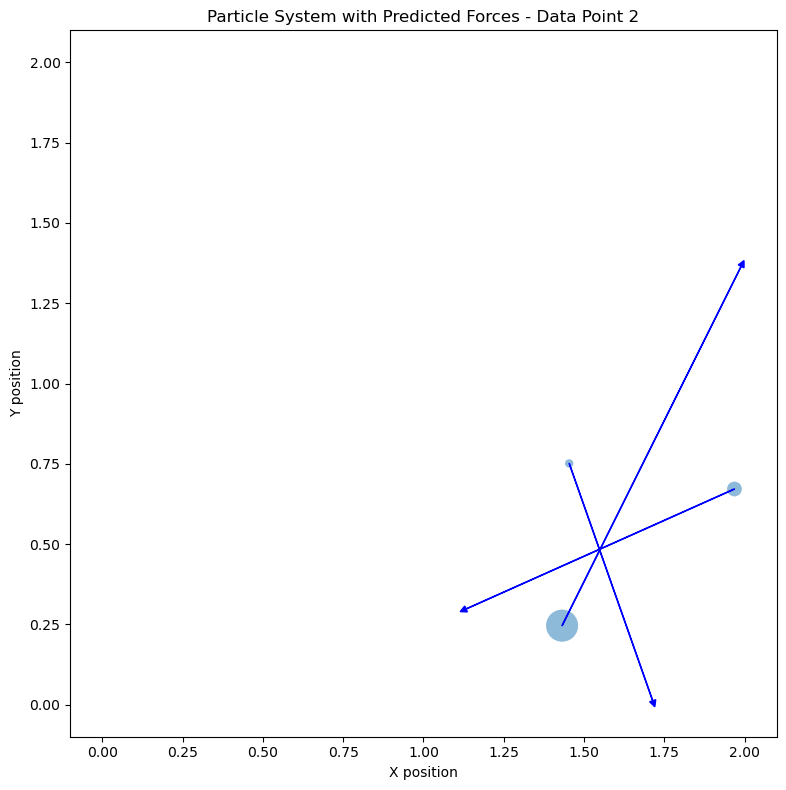

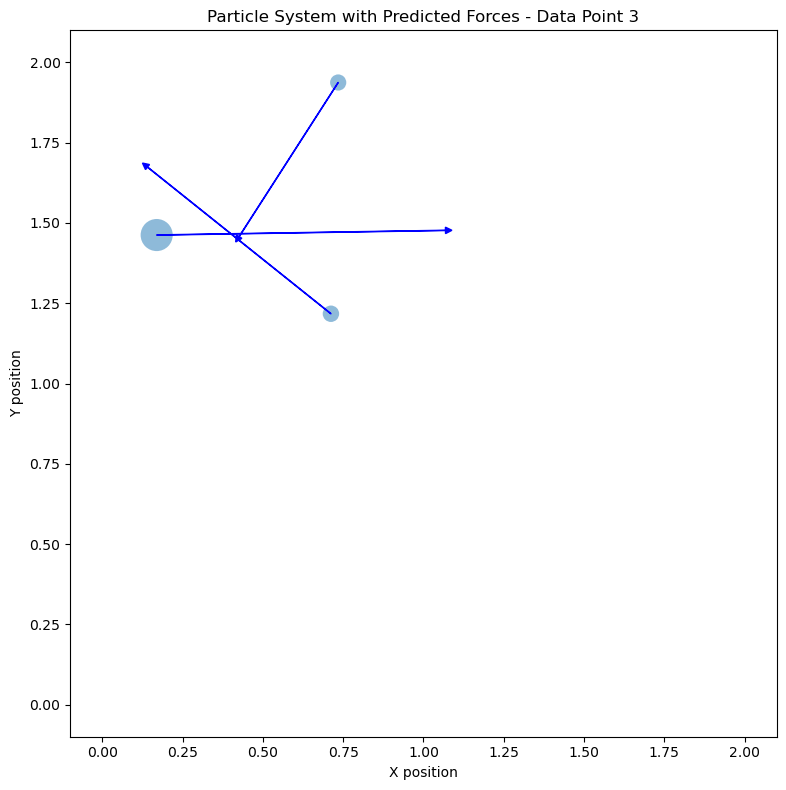

In [8]:
def plot_predicted_forces(data_point, index):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set plot limits
    ax.set_xlim(-0.1, 2.1)
    ax.set_ylim(-0.1, 2.1)
    
    # Find the maximum mass for scaling
    max_mass = max(particle[2] for particle in data_point)
    
    # Plot particles and forces
    for particle in data_point:
        x, y, mass, force = particle
        
        # Plot particle as a circle
        radius = (mass / max_mass) / 20  # Scale radius relative to maximum mass
        circle = plt.Circle((x, y), radius=radius, fill=True, alpha=0.5)
        ax.add_artist(circle)
        
        # Plot predicted force arrow
        force_x, force_y = force
        # Scale arrow length
        scale = 0.02
        ax.arrow(x, y, force_x * scale, force_y * scale, 
                 head_width=0.02, head_length=0.02, fc='b', ec='b')
    
    ax.set_aspect('equal')
    ax.set_title(f'Particle System with Predicted Forces - Data Point {index}')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    
    plt.tight_layout()
    plt.show()

# Plot the predicted forces for the first 3 data points
for i, data_point in enumerate(predicted_particle_dataset[:3]):
    plot_predicted_forces(data_point, i + 1)

Particle A: x=0.15, y=0.61, mass=3.22
Particle B: x=0.68, y=0.78, mass=0.56
Predicted Force on Particle A: Fx=5.74e+00, Fy=1.33e+00



<Figure size 1000x600 with 0 Axes>

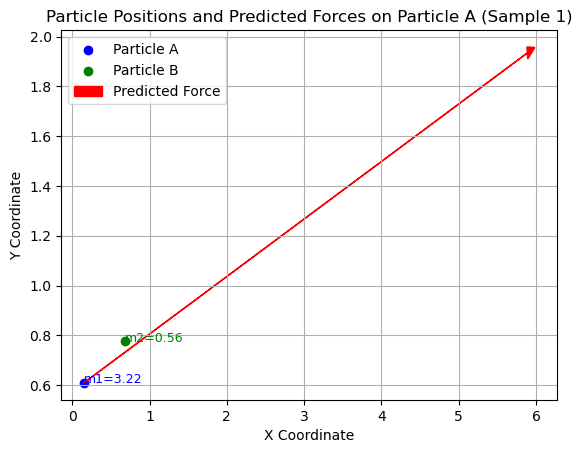

Particle A: x=0.15, y=0.61, mass=3.22
Particle B: x=0.52, y=0.08, mass=1.74
Predicted Force on Particle A: Fx=7.83e+00, Fy=-1.11e+01



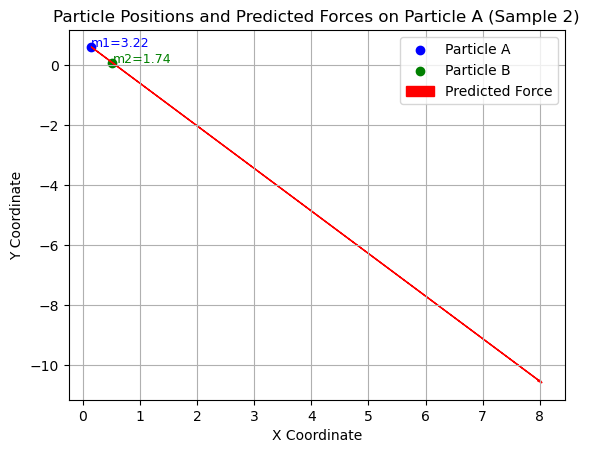

Particle A: x=0.68, y=0.78, mass=0.56
Particle B: x=0.15, y=0.61, mass=3.22
Predicted Force on Particle A: Fx=-5.66e+00, Fy=-2.23e+00



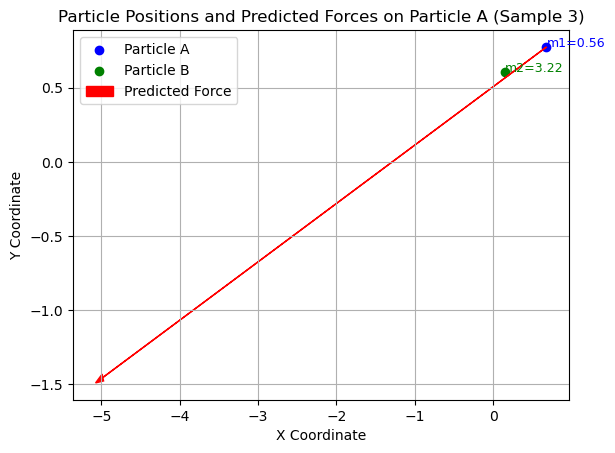

Particle A: x=0.68, y=0.78, mass=0.56
Particle B: x=0.52, y=0.08, mass=1.74
Predicted Force on Particle A: Fx=5.90e-01, Fy=-1.15e+00



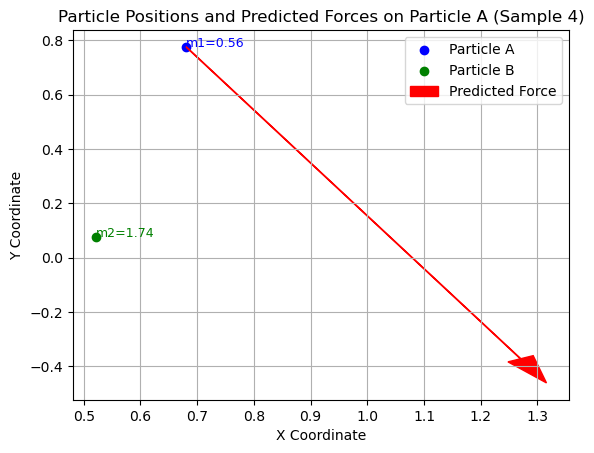

Particle A: x=0.52, y=0.08, mass=1.74
Particle B: x=0.15, y=0.61, mass=3.22
Predicted Force on Particle A: Fx=-8.06e+00, Fy=1.10e+01



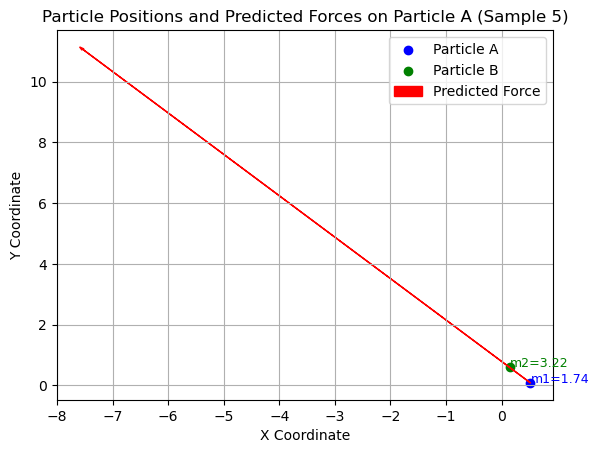

Particle A: x=0.52, y=0.08, mass=1.74
Particle B: x=0.68, y=0.78, mass=0.56
Predicted Force on Particle A: Fx=3.62e-01, Fy=1.58e+00



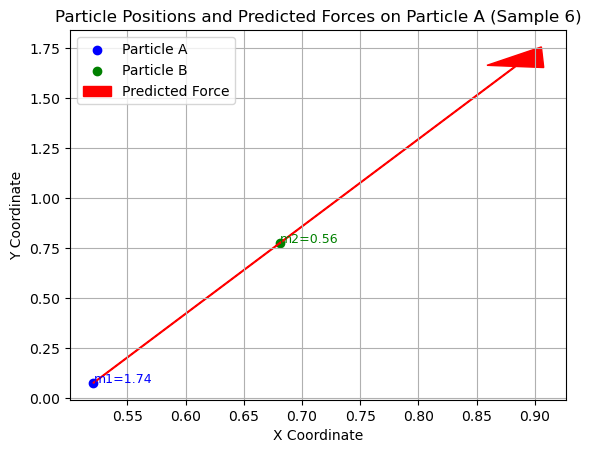

In [10]:
# Organize the data for PySR
input_data = []
predicted_forces = []
for i, data_point in enumerate(particle_dataset[:1000]):
    for j in range(0, 3):
        for k in range(0, 3):
            if j != k:
                particleA = data_point[j][:3]
                particleB = data_point[k][:3]
                input_tensor = torch.tensor(particleA + particleB, dtype=torch.float32)
                input_data.append(input_tensor)
                predicted_forces.append(model.edge_model.mlp(input_tensor.cuda()))

# Convert lists to NumPy arrays
input_data = np.vstack(input_data)
predicted_forces = np.vstack([tensor.cpu().detach().numpy() for tensor in predicted_forces])

# Sample input data and predicted forces from the provided examples
input_data_sample = input_data[:6]  # Extracting the first 6 samples
predicted_forces_sample = predicted_forces[:6]  # Extracting the first 6 predicted forces

plt.figure(figsize=(10, 6))

# Loop over the examples to plot each one
for i in range(len(input_data_sample)):
    # Create a new figure for each plot
    plt.figure()

    # Extract particle data
    x1, y1, mass1, x2, y2, mass2 = input_data_sample[i]
    Fx, Fy = predicted_forces_sample[i]

    # Print particle data
    print(f"Particle A: x={x1:.2f}, y={y1:.2f}, mass={mass1:.2f}")
    print(f"Particle B: x={x2:.2f}, y={y2:.2f}, mass={mass2:.2f}")
    print(f"Predicted Force on Particle A: Fx={Fx:.2e}, Fy={Fy:.2e}\n")

    # Plot particles positions
    plt.scatter(x1, y1, color='blue', label='Particle A')
    plt.scatter(x2, y2, color='green', label='Particle B')

    # Draw force vector on Particle A
    plt.arrow(x1, y1, Fx, Fy, head_width=0.05, head_length=0.1, fc='red', ec='red', label='Predicted Force')

    # Annotate masses
    plt.text(x1, y1, f"m1={mass1:.2f}", fontsize=9, color='blue')
    plt.text(x2, y2, f"m2={mass2:.2f}", fontsize=9, color='green')

    # Set plot properties
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(f'Particle Positions and Predicted Forces on Particle A (Sample {i+1})')
    plt.grid(True)
    plt.legend()
    plt.show()


In [11]:
# from pysr import PySRRegressor

# model = PySRRegressor(
#     niterations=40,
#     binary_operators=["+", "-","*", "/"],
#     unary_operators=["sqrt"],
# )

# model.fit(input_data[:5000], predicted_forces[:5000])